In [1]:
import zipfile

zipfile.ZipFile('/content/dataset.zip', 'r').extractall('/content/dataset')

In [13]:
!pip install torchinfo

## Import Libraries

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import random_split, DataLoader
from torchinfo import summary
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [15]:
#check if cuda is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 48, 3, padding=1)
        self.conv4 = nn.Conv2d(48, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(4, 4)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(7*7*64, 922)
        self.fc2 = nn.Linear(922, 2)
        self.dropout = nn.Dropout(p=0.25)
        self.batchn1 = nn.BatchNorm2d(16)
        self.batchn2 = nn.BatchNorm2d(32)
        self.batchn3 = nn.BatchNorm2d(48)
        self.batchn4 = nn.BatchNorm2d(64)

    def forward(self, x):
        x = self.pool1(F.relu(self.batchn1(self.conv1(x))))
        x = self.pool2(F.relu(self.batchn2(self.conv2(x))))
        x = self.pool2(F.relu(self.batchn3(self.conv3(x))))
        x = self.pool2(F.relu(self.batchn4(self.conv4(x))))
        x = torch.flatten(x, 1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = F.log_softmax(self.fc2(x), dim=1)
        return x

In [17]:
#instantiate the model and move it to the device
model = Classifier().to(device)
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.005)

In [18]:
summary(model, input_size=(1, 3, 224, 224)) # (batch_size, channels, height, width)

Layer (type:depth-idx)                   Output Shape              Param #
Classifier                               [1, 2]                    --
├─Conv2d: 1-1                            [1, 16, 224, 224]         448
├─BatchNorm2d: 1-2                       [1, 16, 224, 224]         32
├─MaxPool2d: 1-3                         [1, 16, 56, 56]           --
├─Conv2d: 1-4                            [1, 32, 56, 56]           4,640
├─BatchNorm2d: 1-5                       [1, 32, 56, 56]           64
├─MaxPool2d: 1-6                         [1, 32, 28, 28]           --
├─Conv2d: 1-7                            [1, 48, 28, 28]           13,872
├─BatchNorm2d: 1-8                       [1, 48, 28, 28]           96
├─MaxPool2d: 1-9                         [1, 48, 14, 14]           --
├─Conv2d: 1-10                           [1, 64, 14, 14]           27,712
├─BatchNorm2d: 1-11                      [1, 64, 14, 14]           128
├─MaxPool2d: 1-12                        [1, 64, 7, 7]             --
├─

## Data Preprocessing

Num of Training data:  8116


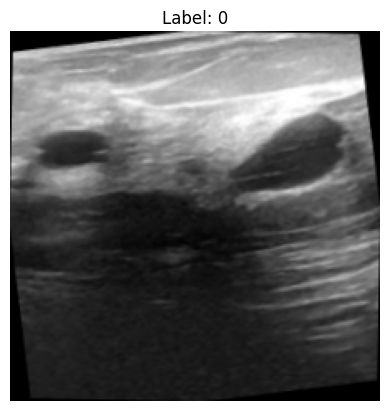

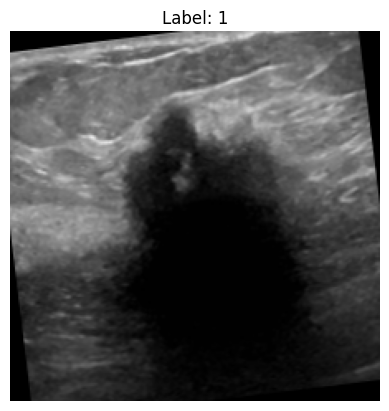

In [19]:
data_dir = '/content/dataset/ultrasound breast classification'
raw_train_data = datasets.ImageFolder(data_dir + '/train')

#len of train and test data
print("Num of Training data: ", len(raw_train_data))

# print a single sample label 0
img, label = raw_train_data[5]
plt.imshow(img)
plt.title(f'Label: {label}')
plt.axis('off')
plt.show()

# print a single sample label 1
img, label = raw_train_data[5000]
plt.imshow(img)
plt.title(f'Label: {label}')
plt.axis('off')
plt.show()

## Data Preperation

Prepare the training and test data loaders using torchvision's ImageFolder

In [20]:
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.RandomRotation(60),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = datasets.ImageFolder(data_dir + '/train', transform=train_transform)
test_dataset = datasets.ImageFolder(data_dir + '/val', transform=test_transform)

# Split into train and validation sets (80% train, 20% validation)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# data loaders
batch_size = 20
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


#check data loader
print("Num of Training batches: ", len(train_loader))
print("Num of Test batches: ", len(test_loader))



Num of Training batches:  325
Num of Test batches:  45


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## Training the Model

Starting epoch 0/30...
Epoch 1/30 - Train Loss: 0.5625, Train Acc: 0.7089, Val Loss: 0.4874, Val Acc: 0.7789
Validation loss decreased (inf → 0.4874). Saving model...
Starting epoch 1/30...
Epoch 2/30 - Train Loss: 0.4768, Train Acc: 0.7706, Val Loss: 0.4269, Val Acc: 0.8054
Validation loss decreased (0.4874 → 0.4269). Saving model...
Starting epoch 2/30...
Epoch 3/30 - Train Loss: 0.4306, Train Acc: 0.7908, Val Loss: 0.4161, Val Acc: 0.8165
Validation loss decreased (0.4269 → 0.4161). Saving model...
Starting epoch 3/30...
Epoch 4/30 - Train Loss: 0.3981, Train Acc: 0.8125, Val Loss: 0.3648, Val Acc: 0.8288
Validation loss decreased (0.4161 → 0.3648). Saving model...
Starting epoch 4/30...
Epoch 5/30 - Train Loss: 0.3711, Train Acc: 0.8259, Val Loss: 0.4115, Val Acc: 0.8159
Starting epoch 5/30...
Epoch 6/30 - Train Loss: 0.3381, Train Acc: 0.8450, Val Loss: 0.4629, Val Acc: 0.7980
Starting epoch 6/30...
Epoch 7/30 - Train Loss: 0.3271, Train Acc: 0.8526, Val Loss: 0.2906, Val Acc: 0.8

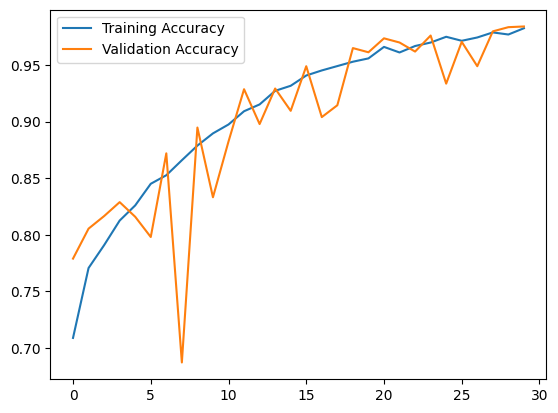

In [21]:
epochs = 30
best_val_loss = np.inf
train_accuracy, val_accuracy = [], []

for epoch in range(epochs):
    running_loss, running_acc = 0.0, 0.0
    model.train()

    print(f'Starting epoch {epoch}/{epochs}...')
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = torch.argmax(logits, dim=1)
        running_acc += (preds == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_acc / len(train_loader.dataset)
    train_accuracy.append(epoch_acc)

    # Validation Loop
    model.eval()
    val_loss, val_acc = 0.0, 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            loss = criterion(logits, labels)

            val_loss += loss.item() * images.size(0)
            preds = torch.argmax(logits, dim=1)
            val_acc += (preds == labels).sum().item()

    val_loss = val_loss / len(val_loader.dataset)
    val_acc = val_acc / len(val_loader.dataset)
    val_accuracy.append(val_acc)

    print(f'Epoch {epoch+1}/{epochs} - '
          f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    # Save Best Model
    if val_loss < best_val_loss:
        print(f"Validation loss decreased ({best_val_loss:.4f} → {val_loss:.4f}). Saving model...")
        torch.save(model.state_dict(), 'best_model.pt')
        best_val_loss = val_loss

# Load Best Model
model.load_state_dict(torch.load('best_model.pt'))

# Plot Accuracy
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.legend()
plt.show()


## Evaluation

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Test NLLLoss: 0.183818
Test Accuracy: 0.948889

Classification Report:

              precision    recall  f1-score   support

      Benign       0.99      0.92      0.95       500
   Malignant       0.90      0.99      0.95       400

    accuracy                           0.95       900
   macro avg       0.95      0.95      0.95       900
weighted avg       0.95      0.95      0.95       900



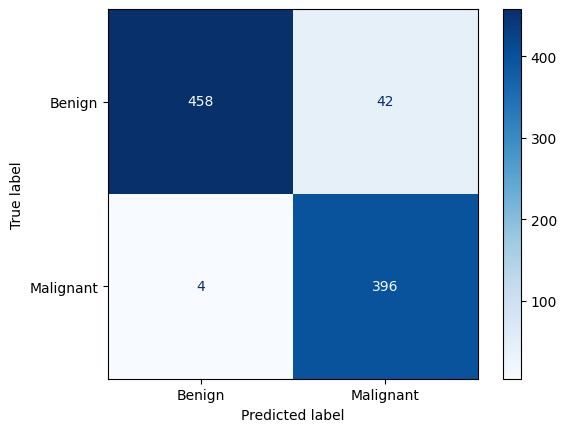

In [24]:
def evaluate(model, test_loader, criterion):
    test_loss, test_acc = 0.0, 0.0
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            nllloss = criterion(logits, labels)
            preds = torch.argmax(logits, dim=1)

            test_loss += nllloss.item() * images.size(0)
            test_acc += (preds == labels).sum().item()

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    test_loss = test_loss / len(test_loader.dataset)
    test_acc = test_acc / len(test_loader.dataset)

    # Print NLLLoss and Accuracy
    print(f'\nTest Loss: {test_loss:.6f}')
    print(f'Test Accuracy: {test_acc:.6f}')

    # Classification Report
    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, target_names=['Benign', 'Malignant']))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malignant'])
    disp.plot(cmap='Blues')
    plt.show()

# Test Model
evaluate(model, test_loader, criterion)